In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fftpack import ifft,fft
from scipy.signal import hilbert

#functions from XDU_rf code, I used the unintegarted version, the latest script 'XDU RF chain code.py' contains all functions
import sys
sys.path.append(r'/Users/zkw/scripts/voltagecalculate_1125/')
from FFT_get import fftget
from IFFT_get import ifftget
from Filterparameter import filter_get
from galacticnoise_get import gala
from Time_domain_Shower_Edata_get import time_data_get

E_path='/Users/zkw/scripts/voltagecalculate_1125/test/Stshp_MZS_QGS204JET_Proton_3.98_79.6_90.0_9/Stshp_MZS_QGS204JET_Proton_3.98_79.6_90.0_9_trace/a0.trace'
Ts = 0.5 
lst = 18
[t_cut, ex_cut, ey_cut, ez_cut, fs, f0, f, f1, N] = time_data_get(E_path, Ts, 0)
Edata = ex_cut
Edata = np.column_stack((Edata, ey_cut))
Edata = np.column_stack((Edata, ez_cut))
[E_shower_fft, E_shower_fft_m_single, E_shower_fft_p_single] = fftget(Edata, N, f1,0)

[cable_coefficient, filter_coefficient] = filter_get(2000, f0, 1, 0)
[galactic_v_complex_double, galactic_v_time] = gala(lst, N, f0, f1, 0)


In [3]:
from equivalent import CEL
e_theta = 79.6
e_phi = 90.0
#effective length matrix
[Lce_complex, antennas11_complex_short] = CEL(e_theta, e_phi, 2000, f0, 1, 0)

Text(0, 0.5, 'Ez')

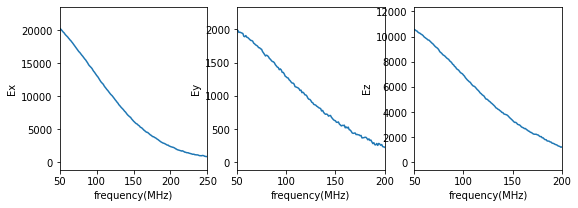

In [10]:
Voc_shower_complex = np.zeros((2000, 3), dtype=complex)
for p in range(3):
    Voc_shower_complex[:, p] = Lce_complex[:, 0, p] * E_shower_fft[:, 0] + Lce_complex[:, 1, p] * E_shower_fft[:,1] + Lce_complex[:, 2,p] * E_shower_fft[:,2] + 0

    
[Voc_shower_t, Voc_shower_m_single, Voc_shower_p_single] = ifftget(Voc_shower_complex, N, f1, 2)
Voc_noise_complex = np.zeros((2000, 3), dtype=complex)
Voc_noise_t = np.zeros((2000, 3))
for p in range(3):
    Voc_noise_t[:, p] = Voc_shower_t[:, p] + galactic_v_time[:, p]
    Voc_noise_complex[:, p] = Voc_shower_complex[:, p] + galactic_v_complex_double[:, p]
    
plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.plot(f,abs(E_shower_fft[:,0]))
plt.xlim([50,200])
plt.xlabel('frequency(MHz)')
plt.ylabel('Ex')
plt.subplot(1, 3, 2)
plt.plot(f,abs(E_shower_fft[:,1]))
plt.xlim([50,200])
plt.xlabel('frequency(MHz)')
plt.ylabel('Ey')
plt.subplot(1, 3, 3)
plt.plot(f,abs(E_shower_fft[:,2]))
plt.xlim([50,200])
plt.xlabel('frequency(MHz)')
plt.ylabel('Ez')



$y(t)=(h*x)(t)+N(t)$


$\hat{x}(t)=(g*y)(t)$

where $\hat{x}(t)$ minimizes the mean square error

$\epsilon(t)=\mathbb{E} \left| x(t) - \hat{x}(t) \right|^2$

in frequency domain $\hat{X}(f)=G(f)Y(f)$

where $G(f)=\frac{H^*(f)S(f)}{|H(f)|^2S(f)+N(f)}$,$S(f) = \mathbb{E}|X(f)|^2$,$N(f) = \mathbb{E}|N(f)|^2$

In [13]:
Lce_complex_conj=np.conjugate(Lce_complex)
Lce_complex_amp=abs(Lce_complex)**2

#spectrum is extended, here I choose the frequency range [50,200]
S_mean1=sum(abs(E_shower_fft[:,0][49:199])**2)/150
S_mean2=sum(abs(E_shower_fft[:,1][49:199])**2)/150
S_mean3=sum(abs(E_shower_fft[:,2][49:199])**2)/150

N_mean1=sum(abs(galactic_v_complex_double[:,0][49:199])**2)/150
N_mean2=sum(abs(galactic_v_complex_double[:,1][49:199])**2)/150
N_mean3=sum(abs(galactic_v_complex_double[:,2][49:199])**2)/150

HS=np.zeros(np.shape(E_shower_fft),dtype='complex')#numerator of G(f)
G=np.zeros(np.shape(E_shower_fft),dtype='complex')

for i in range(2000):
    if i>=49 and i <200:
        HS[i,0]=Lce_complex_conj[i, 0, 0]*S_mean1+Lce_complex_conj[i, 1, 0]*S_mean2+Lce_complex_conj[i, 2, 0]*S_mean3
        HS[i,1]=Lce_complex_conj[i, 0, 1]*S_mean1+Lce_complex_conj[i, 1, 1]*S_mean2+Lce_complex_conj[i, 2, 1]*S_mean3
        HS[i,2]=Lce_complex_conj[i, 0, 2]*S_mean1+Lce_complex_conj[i, 1, 2]*S_mean2+Lce_complex_conj[i, 2, 2]*S_mean3
    else:
        HS[i,:]=0

for i in range(2000):
    G[i,0]=HS[i,0]/(Lce_complex_amp[i, 0, 0]*S_mean1+Lce_complex_amp[i, 1, 0]*S_mean2+Lce_complex_amp[i, 2, 0]*S_mean3+N_mean1)
    G[i,1]=HS[i,1]/(Lce_complex_amp[i, 0, 1]*S_mean1+Lce_complex_amp[i, 1, 1]*S_mean2+Lce_complex_amp[i, 2, 1]*S_mean3+N_mean2)
    G[i,2]=HS[i,2]/(Lce_complex_amp[i, 0, 2]*S_mean1+Lce_complex_amp[i, 1, 2]*S_mean2+Lce_complex_amp[i, 2, 2]*S_mean3+N_mean3)

In [18]:
Ehat=np.zeros(np.shape(E_shower_fft),dtype='complex')
for i in range(3):
    Ehat[:,i]=G[:,i]*Voc_noise_complex[:,i]
    

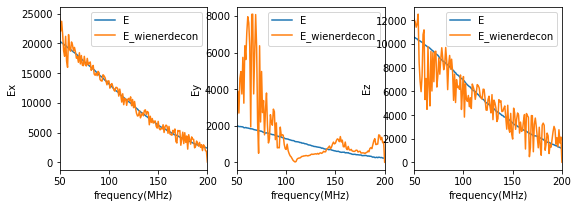

In [19]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.plot(f,abs(E_shower_fft[:,0]),label='E')
plt.plot(f,abs(Ehat[:,0]),label='E_wienerdecon')
plt.xlim([50,200])
plt.xlabel('frequency(MHz)')
plt.ylabel('Ex')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(f,abs(E_shower_fft[:,1]),label='E')
plt.plot(f,abs(Ehat[:,1]),label='E_wienerdecon')
plt.xlim([50,200])
plt.xlabel('frequency(MHz)')
plt.ylabel('Ey')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(f,abs(E_shower_fft[:,2]),label='E')
plt.plot(f,abs(Ehat[:,2]),label='E_wienerdecon')
plt.xlim([50,200])
plt.xlabel('frequency(MHz)')
plt.ylabel('Ez')
plt.legend()